In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset, to_spectrogram_dataset
from src.model import get_seq_model, get_conv_model, callbacks, get_conv_model_mini
from src.plots import plot_history, plot_mfccs, plot_spectrograms
LEARNING_RATE = 0.0001
# train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure", 0.2, 16)
train_ds, val_ds, label_names = dataset_tf("dataset/osbh-pitched-10", 0.2, 16)

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (16, 4000)
Example label shape: (16,)


2024-03-28 23:50:07.329331: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-03-28 23:50:07.329354: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-03-28 23:50:07.329360: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-03-28 23:50:07.329393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-28 23:50:07.329409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [2]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)
train_spectrogram_ds = to_spectrogram_dataset(train_ds)
val_spectrogram_ds = to_spectrogram_dataset(val_ds)

513 44100
513 44100


# Initial models (OSBH)

## MFCCs

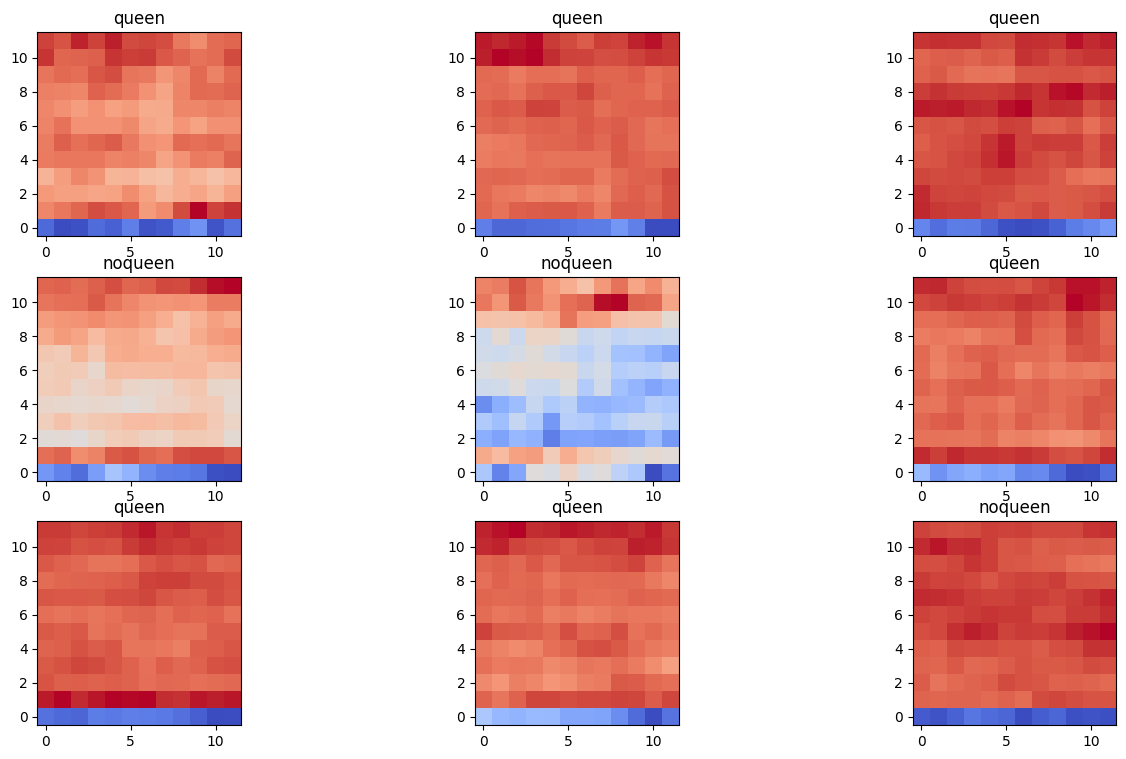

In [3]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [4]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 12, 1])

In [5]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

### [MFCCs] Sequential model

2024-03-28 23:50:08.896318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/20


2024-03-28 23:50:09.621315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


43/43 [==============================] - 1s 19ms/step - loss: 0.6261 - accuracy: 0.6102 - val_loss: 0.5979 - val_accuracy: 0.6433
Epoch 2/20
43/43 [==============================] - 0s 10ms/step - loss: 0.5486 - accuracy: 0.7372 - val_loss: 0.5182 - val_accuracy: 0.7836
Epoch 3/20
43/43 [==============================] - 0s 10ms/step - loss: 0.4471 - accuracy: 0.8161 - val_loss: 0.4499 - val_accuracy: 0.8304
Epoch 4/20
43/43 [==============================] - 0s 10ms/step - loss: 0.3852 - accuracy: 0.8526 - val_loss: 0.4156 - val_accuracy: 0.8304
Epoch 5/20
43/43 [==============================] - 0s 10ms/step - loss: 0.3503 - accuracy: 0.8628 - val_loss: 0.4094 - val_accuracy: 0.8363
Epoch 6/20
43/43 [==============================] - 0s 10ms/step - loss: 0.3138 - accuracy: 0.8818 - val_loss: 0.3898 - val_accuracy: 0.8480
Epoch 7/20
43/43 [==============================] - 0s 10ms/step - loss: 0.2881 - accuracy: 0.8934 - val_loss: 0.3889 - val_accuracy: 0.8421
Epoch 8/20
43/43 [======

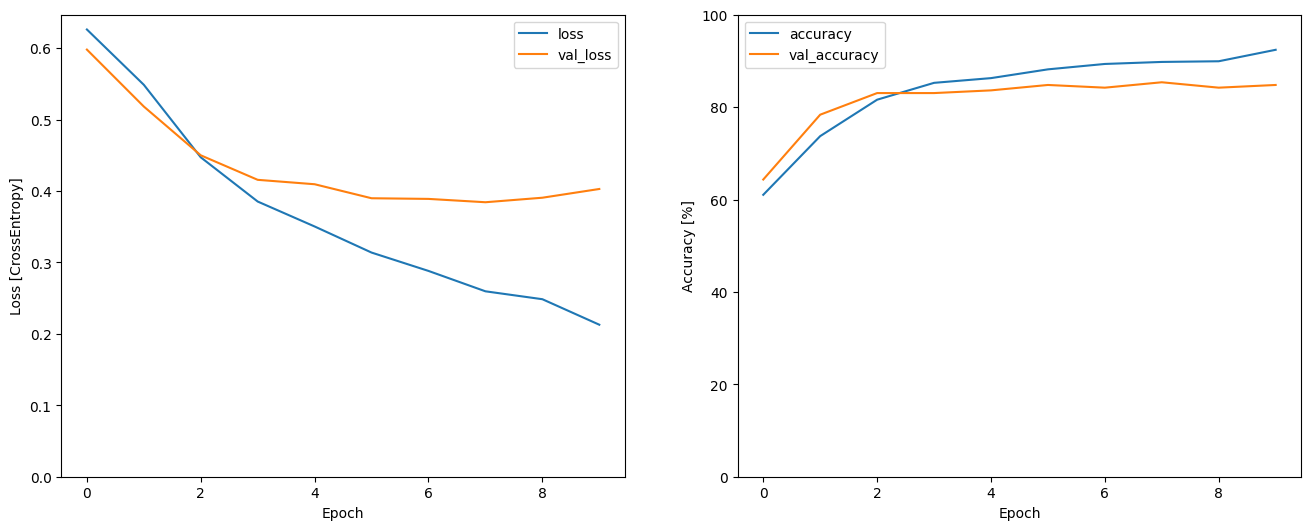

In [6]:
model_mfcc_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_mfcc_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_mfcc_seq = model_mfcc_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_seq)

### [MFCCs] Convolutional model (mini)

Epoch 1/20
43/43 [==============================] - 1s 9ms/step - loss: 0.6263 - accuracy: 0.6336 - val_loss: 0.6114 - val_accuracy: 0.7485
Epoch 2/20
43/43 [==============================] - 0s 5ms/step - loss: 0.5769 - accuracy: 0.6934 - val_loss: 0.5602 - val_accuracy: 0.7076
Epoch 3/20
43/43 [==============================] - 0s 5ms/step - loss: 0.5300 - accuracy: 0.7737 - val_loss: 0.5199 - val_accuracy: 0.7193
Epoch 4/20
43/43 [==============================] - 0s 5ms/step - loss: 0.4930 - accuracy: 0.8204 - val_loss: 0.4806 - val_accuracy: 0.8129
Epoch 5/20
43/43 [==============================] - 0s 5ms/step - loss: 0.4633 - accuracy: 0.8307 - val_loss: 0.4508 - val_accuracy: 0.8129
Epoch 6/20
43/43 [==============================] - 0s 5ms/step - loss: 0.4391 - accuracy: 0.8365 - val_loss: 0.4453 - val_accuracy: 0.8421
Epoch 7/20
43/43 [==============================] - 0s 5ms/step - loss: 0.4166 - accuracy: 0.8540 - val_loss: 0.4200 - val_accuracy: 0.8480
Epoch 8/20
43/43 [==

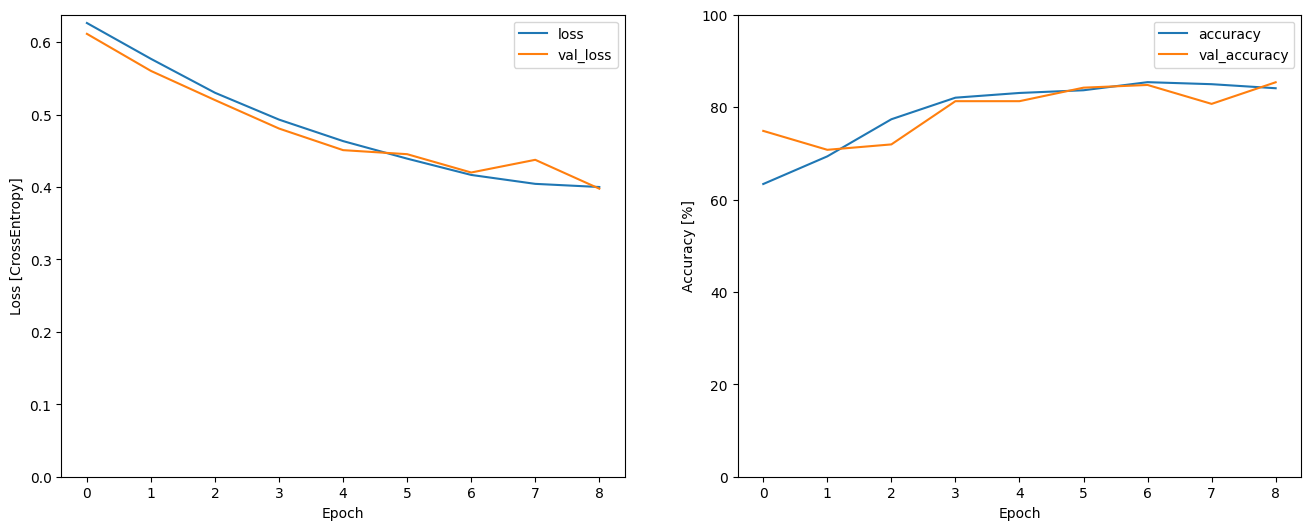

In [7]:
model_mfcc_conv = get_conv_model(input_shape, len(label_names))
model_mfcc_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_mfcc_conv = model_mfcc_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_mfcc_conv)

## Spectrograms

(118, 129, 1)


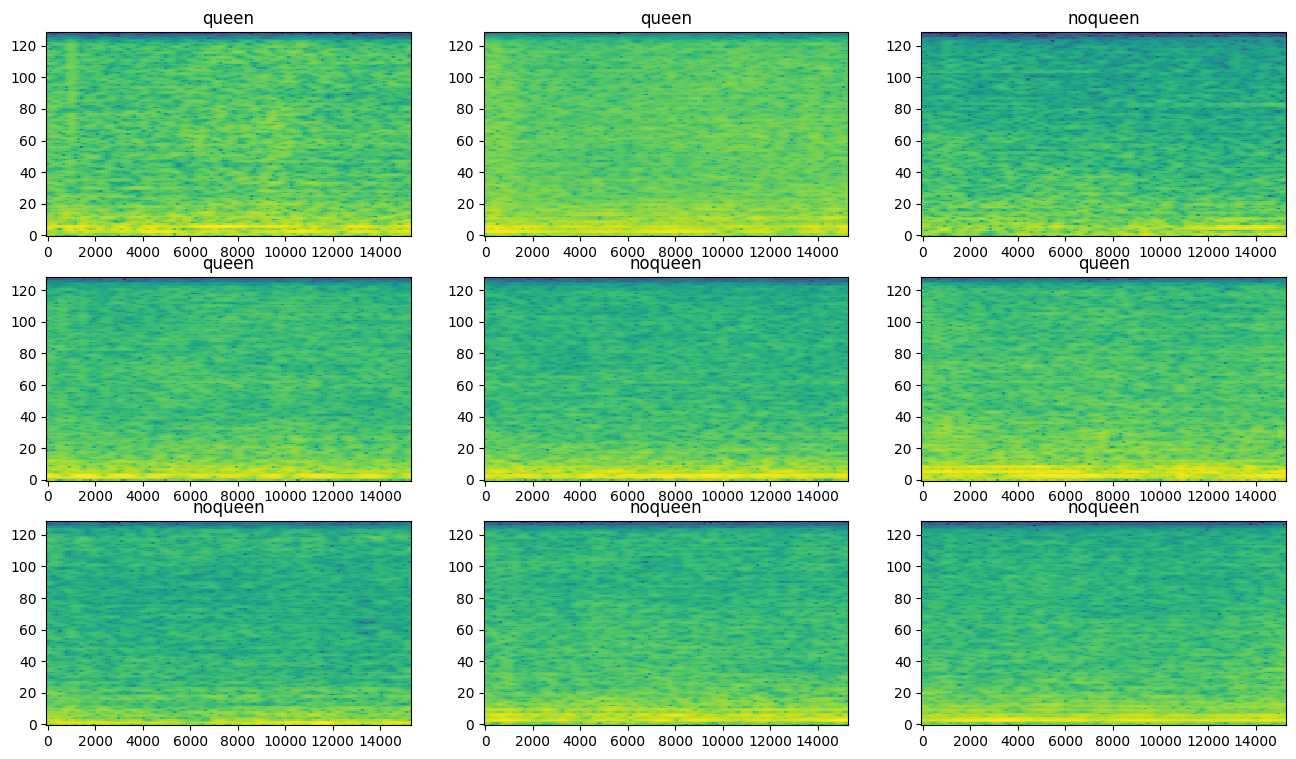

In [8]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
print(input_shape)
plot_spectrograms(example_spectrograms, example_spect_labels, label_names)

In [9]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

### [Spec] Sequential model

Epoch 1/20
43/43 [==============================] - 1s 16ms/step - loss: 0.6565 - accuracy: 0.6131 - val_loss: 0.6385 - val_accuracy: 0.6199
Epoch 2/20
43/43 [==============================] - 0s 10ms/step - loss: 0.6142 - accuracy: 0.6190 - val_loss: 0.6132 - val_accuracy: 0.6140
Epoch 3/20
43/43 [==============================] - 0s 10ms/step - loss: 0.5741 - accuracy: 0.6876 - val_loss: 0.5720 - val_accuracy: 0.6199
Epoch 4/20
43/43 [==============================] - 0s 10ms/step - loss: 0.5164 - accuracy: 0.7445 - val_loss: 0.5159 - val_accuracy: 0.7953
Epoch 5/20
43/43 [==============================] - 0s 10ms/step - loss: 0.4686 - accuracy: 0.7766 - val_loss: 0.5342 - val_accuracy: 0.6667
Epoch 6/20
43/43 [==============================] - 0s 10ms/step - loss: 0.4289 - accuracy: 0.7985 - val_loss: 0.4820 - val_accuracy: 0.7368


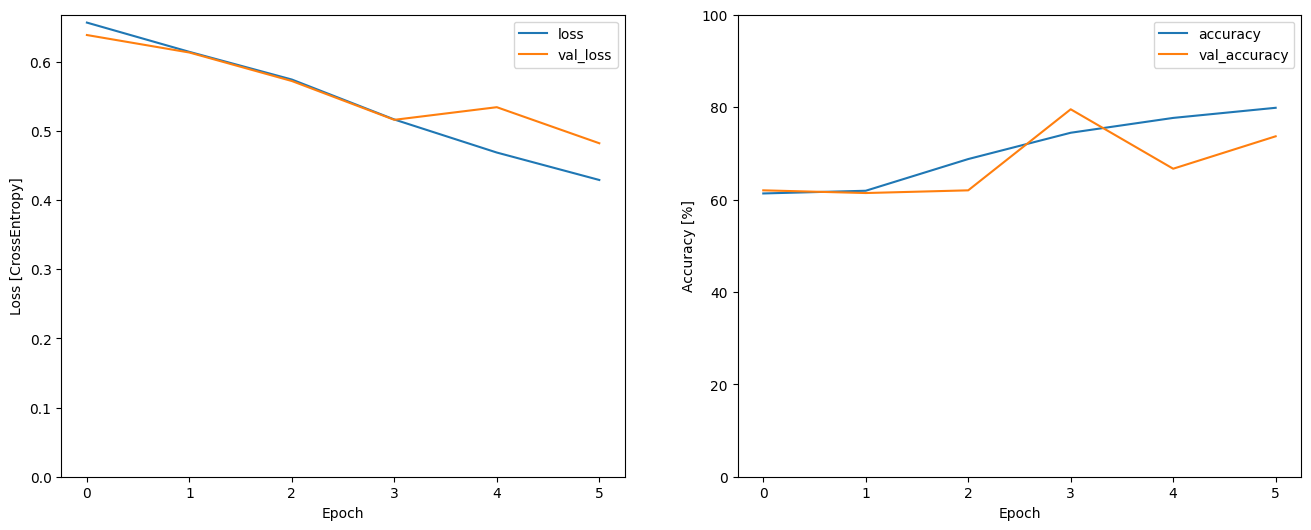

In [10]:
model_spec_seq = get_seq_model(input_shape, len(label_names), train_spectrogram_ds)
model_spec_seq.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history_spec_seq = model_spec_seq.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_seq)

### [Spec] Convolutional model

Epoch 1/20
43/43 [==============================] - 1s 11ms/step - loss: 0.6384 - accuracy: 0.6161 - val_loss: 0.6297 - val_accuracy: 0.6140
Epoch 2/20
43/43 [==============================] - 0s 9ms/step - loss: 0.5979 - accuracy: 0.6526 - val_loss: 0.5921 - val_accuracy: 0.6550
Epoch 3/20
43/43 [==============================] - 0s 6ms/step - loss: 0.5498 - accuracy: 0.7255 - val_loss: 0.5486 - val_accuracy: 0.8246
Epoch 4/20
43/43 [==============================] - 0s 6ms/step - loss: 0.5063 - accuracy: 0.7898 - val_loss: 0.5543 - val_accuracy: 0.6784
Epoch 5/20
43/43 [==============================] - 0s 7ms/step - loss: 0.4576 - accuracy: 0.8073 - val_loss: 0.4868 - val_accuracy: 0.8246
Epoch 6/20
43/43 [==============================] - 0s 8ms/step - loss: 0.4257 - accuracy: 0.8336 - val_loss: 0.4762 - val_accuracy: 0.8304
Epoch 7/20
43/43 [==============================] - 0s 9ms/step - loss: 0.4229 - accuracy: 0.8204 - val_loss: 0.4624 - val_accuracy: 0.8596
Epoch 8/20
43/43 [=

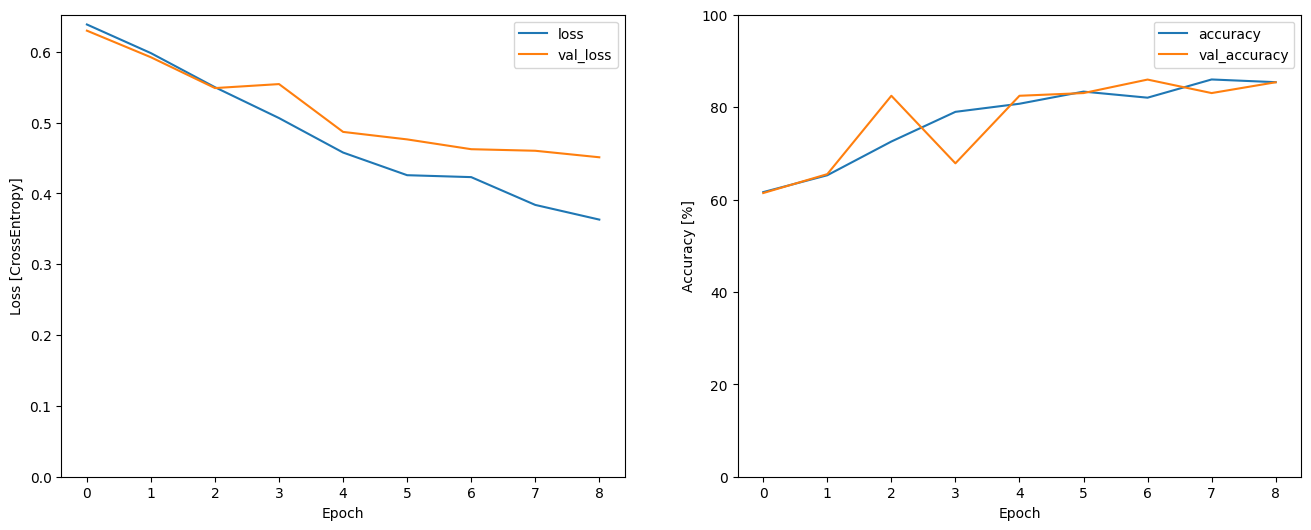

In [11]:
model_spec_conv = get_conv_model_mini(input_shape, len(label_names))
model_spec_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)
history_spec_conv = model_spec_conv.fit(
    train_spectrogram_ds, 
    validation_data=val_spectrogram_ds, 
    epochs=20,
    callbacks=callbacks
)
plot_history(history_spec_conv)

# Save models

In [12]:
model_mfcc_seq.save('models/mfcc_seq.h5')
model_mfcc_conv.save('models/mfcc_conv_mini.h5')
model_spec_seq.save('models/spec_seq.h5')
model_spec_conv.save('models/spec_conv.h5')

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
history_spec_conv

# Summary

In [14]:
def history_to_summary(prefix: str, history):
    print(f"{prefix}:    Loss: {history.history['loss'][-1]:.2f}, Acc: {history.history['accuracy'][-1]:.2f}, Val. Loss: {history.history['val_loss'][-1]:.2f}, Val. Acc: {history.history['val_accuracy'][-1]:.2f}" )

history_to_summary("MFCCs + Sequential model       ", history_mfcc_seq)
history_to_summary("MFCCs + Conv model             ", history_mfcc_conv)
history_to_summary("Spectrogram + Sequential model ", history_spec_seq)
history_to_summary("Spectrogram + Conv model       ", history_spec_conv)


MFCCs + Sequential model       :    Loss: 0.21, Acc: 0.92, Val. Loss: 0.40, Val. Acc: 0.85
MFCCs + Conv model             :    Loss: 0.40, Acc: 0.84, Val. Loss: 0.40, Val. Acc: 0.85
Spectrogram + Sequential model :    Loss: 0.43, Acc: 0.80, Val. Loss: 0.48, Val. Acc: 0.74
Spectrogram + Conv model       :    Loss: 0.36, Acc: 0.85, Val. Loss: 0.45, Val. Acc: 0.85
